**Mount Google Drive To Retrieve Data From Cloud Storage**

In [ ]:
# Dataset: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import Dependencies**

In [194]:
import re
import csv
import nltk
import zipfile
import numpy as np
import pandas as pd
import wordcloud
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

**Load and Display Raw Data**

In [155]:
# Load raw data
SAVE_PATH = 'gdrive/MyDrive/Sentiment_Analysis/'
raw_data = pd.read_csv(SAVE_PATH + 'data/IMDB_Dataset.csv')
raw_data.review = raw_data.review.astype(str)

print("Before cleaning:\n", raw_data.head())
print("\n", raw_data.shape)

Before cleaning:
                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

 (50000, 2)


**Clean Data**

In [158]:
'''
Clean dataset by remoiving noise from html, symbols, stop words
Stem words to their root word using nltk
'''

def denoise_text(text):
    soup = BeautifulSoup(text, 'html.parser')       # trim html format out
    new_text = soup.get_text()
    new_text = re.sub('\[[^]]*\]', '', new_text)    # remove between square brackets
    return new_text

def remove_special_chars(text):
    # pattern = r'[^a-zA-Z0-9\s]'                   # Allow numbers
    pattern = r'[^a-zA-Z\s]'                        # raw regex, exclude everything except letters and a space
    new_text = re.sub(pattern, '', text)
    return new_text

def stemmer(text):
    ps = nltk.porter.PorterStemmer()                # convert similar words to root word
    new_text = ' '.join([ps.stem(word) for word in text.split()])
    return new_text

def remove_stops(text):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    stop_words = set(stopwords.words("english"))
    new_text = ' '.join([w for w in tokens if w not in stop_words])
    return new_text


def trim_data(data):
    # Remove html strips and all noises text
    data['review'] = data['review'].apply(denoise_text)

    # Remove special chars
    data['review'] = data['review'].apply(remove_special_chars)

    # convert all text in 'review' column to lowercase
    data['review'] = data['review'].str.lower()

    # remove stopwords
    data['review'] = data['review'].apply(remove_stops)

    # Stem all word to their common word
    data['review'] = data['review'].apply(stemmer)


def clean(data, display=True):
  # Download necessary nltk corpus if not exist
  try:
      nltk.data.find('stopwords')
  except LookupError:
      nltk.download('stopwords')

  # Clean and save data
  trim_data(data)
  data.to_csv(SAVE_PATH + 'data/Cleaned_IMDB_Dataset.csv', index=False)
  
  if(display):
    print("After cleaning:\n", raw_data.head())
    print("\n", raw_data.shape)

clean(raw_data)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
After cleaning:
                                               review sentiment
0  one review mention watch oz episod youll hook ...  positive
1  wonder littl product film techniqu unassum old...  positive
2  thought wonder way spend time hot summer weeke...  positive
3  basic there famili littl boy jake think there ...  negative
4  petter mattei love time money visual stun film...  positive

 (50000, 2)


**Load and Display Cleaned Data**

In [199]:
# Load raw pre-cleaned data
SAVE_PATH = 'gdrive/MyDrive/Sentiment_Analysis/'
data = pd.read_csv(SAVE_PATH + 'data/Cleaned_No_Stemming_IMDB_Dataset.csv')
data.review = data.review.astype(str)

print(data.head)
print("\n", data.shape)

<bound method NDFrame.head of                                                   review sentiment
0      one reviewers mentioned watching oz episode yo...  positive
1      wonderful little production filming technique ...  positive
2      thought wonderful way spend time hot summer we...  positive
3      basically theres family little boy jake thinks...  negative
4      petter matteis love time money visually stunni...  positive
...                                                  ...       ...
49995  thought movie right good job wasnt creative or...  positive
49996  bad plot bad dialogue bad acting idiotic direc...  negative
49997  catholic taught parochial elementary schools n...  negative
49998  im going disagree previous comment side maltin...  negative
49999  one expects star trek movies high art fans exp...  negative

[50000 rows x 2 columns]>

 (50000, 2)


**Exploratory Data Analysis**

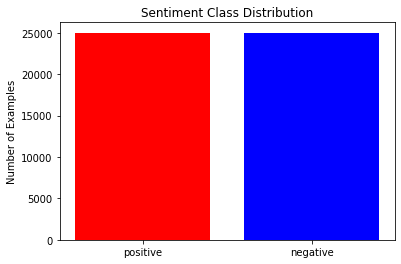

In [201]:
pos_reviews = data[data.sentiment == 'positive']
neg_reviews = data[data.sentiment == 'negative']

# Plot class distribution
plt.bar(x=['positive', 'negative'], height=[len(pos_reviews), len(neg_reviews)], color=['red', 'blue'])
plt.title('Sentiment Class Distribution')
plt.ylabel('Number of Examples')
plt.savefig(SAVE_PATH + 'figures/class_distr.png')
plt.show()

**Review Length Distribution**

Positive Reviews:
  Longest review length: 8356 characters
  Shortest review length: 31 characters
  Avg review length: 752 characters

Negative Reviews:
  Longest review length: 5127 characters
  Shortest review length: 17 characters
  Avg review length: 726 characters


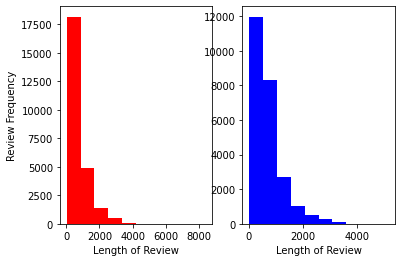

In [ ]:
# Length of review
fig, (ax1, ax2) = plt.subplots(1, 2)
print("Positive Reviews:")
pos_lens = [len(text) for text in pos_reviews['review'].values]
print("  Longest review length:", max(pos_lens), "characters")
print("  Shortest review length:", min(pos_lens), "characters")
print("  Avg review length:", round(sum(pos_lens) / len(pos_lens)), "characters")
ax1.hist(pos_lens, color='red')
ax1.set_xlabel("Length of Review")
ax1.set_ylabel("Review Frequency")

print("\nNegative Reviews:")
neg_lens = [len(text) for text in neg_reviews['review'].values]
print("  Longest review length:", max(neg_lens), "characters")
print("  Shortest review length:", min(neg_lens), "characters")
print("  Avg review length:", round(sum(neg_lens) / len(neg_lens)), "characters")
ax2.hist(neg_lens, color='blue')
ax2.set_xlabel("Length of Review")

# Display and save histogram plots
fig.show()
fig.savefig(SAVE_PATH + 'figures/length_hist.png')


**Highest Frequency Words Per Review Class**

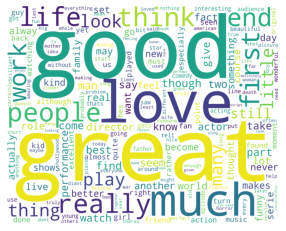

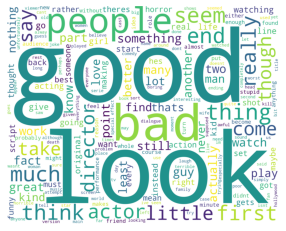

In [202]:
# Add domain specific stop words
exclude = list(wordcloud.STOPWORDS)
exclude.extend([
                    'film', 'films', 'one', 'movie', 'movies', 'characters', 'director'
                    'character', 'scene', 'scenes', 'story', 'time', 'show', 
                    'even', 'plot', 'make', 'made', 'see', 'well', 'way'
              ])
exclude = set(exclude)

# Generate wordcloud based on most common words in positive/negative reviews
pos_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(pos_reviews['review'].values))
neg_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(neg_reviews['review'].values))

# Display wordcloud images
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.show()
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.show()

# Save word clouds
pos_wordcloud.to_file(SAVE_PATH + 'figures/pos_cloud.png')
neg_wordcloud.to_file(SAVE_PATH + 'figures/neg_cloud.png')

**Separate Review Text and Labels**

In [ ]:
x_vals = data['review'].values
y_vals = data['sentiment'].values
print("Review Text:\n------------\n", x_vals)
print("\nSentiment:\n----------\n", y_vals)

Review Text:
------------
 ['one review mention watch oz episod youll hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison e

**Load Pre-trained Word Embedding GloVe**

In [ ]:
# Load and GloVe pre-trained word embedding 
# (trained on 2B tweets, 27B tokens, 1.2M vocab, uncased)
# https://nlp.stanford.edu/projects/glove

# Map each word to its 100 pre-trained weights
embeddings = {}
with open(SAVE_PATH + 'data/glove.twitter.27B.100d.txt', 'r') as embed_file:
  for line in embed_file:
    word_weights = line.split()
    word = word_weights[0]
    weights = np.asarray(word_weights[1:], dtype='float32')
    embeddings[word] = weights

print(len(embeddings))

1193514


**Use Tokenizer to Build Vocabulary and Vectorize Text**

In [ ]:
# Train a tokenizer on the vocabulary of the text in the dataset
tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(data['review'].values)

# Convert text to padded sequential data of fixed length
# to matched retrained GloVe embedding of dimension 100
NUM_FEATURES = 100
x_vals = tokenizer.texts_to_sequences(data['review'].values)
x_vals = pad_sequences(x_vals, padding='post', maxlen=NUM_FEATURES)

print(x_vals)
print("\n", x_vals.shape)

[[ 520 1093 1268 ...  450 3343  389]
 [ 107   51  222 ...    0    0    0]
 [  99  107   33 ...    0    0    0]
 ...
 [3719 3526 1591 ...  438 3260 1064]
 [  70   25 2357 ...    0    0    0]
 [   3  155   90 ...    0    0    0]]

 (50000, 100)


**Generate Weight Matrix for IMDB Dataset**

In [ ]:
# Use the pretrained GloVe embedding weights for each word
VOCAB_SIZE = len(tokenizer.word_index) + 1
w_matrix = np.zeros((VOCAB_SIZE, NUM_FEATURES))

for word, index in tokenizer.word_index.items():
    if(word in embeddings):
        w_matrix[index] = embeddings[word]

print("\n", w_matrix)
print("\n", w_matrix.shape)


 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.29233    -0.085156   -0.29183    ...  0.38835999  0.092125
   0.62006998]
 [ 0.65911001  0.12594    -0.57656002 ... -0.38909999 -0.29971001
  -0.65749002]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]

 (174786, 100)


**Create Pre-trained Embedding Layer**

In [ ]:
embedding_layer = Embedding(
    input_dim=VOCAB_SIZE, 
    output_dim=100, 
    weights=[w_matrix], 
    input_length=NUM_FEATURES, 
    trainable=False
)

**Vectorize Sentiment Labels**

In [ ]:
# Convert positive labels to 1, negative to 0
y_vals[y_vals == 'positive'] = 1
y_vals[y_vals == 'negative'] = 0
y_vals.resize((y_vals.shape[0], 1))
y_vals = np.asarray(y_vals).astype(np.int)

print(y_vals)
print("\n", y_vals.shape)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]

 (50000, 1)


**Partition Data**

In [ ]:
from sklearn.model_selection import train_test_split

# Randomize and split entire dataset into 80% train, 20% validation
x_train, x_valid, y_train, y_valid = train_test_split(x_vals, y_vals, test_size=.2, random_state=5)

# Split from the 10% of the entire dataset into testing (from the partitioned training data)
# 0.125 * 0.8 = 0.1
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.125, random_state=5) 

print("Training:", x_train.shape, y_train.shape)
print("Validation:", x_valid.shape, y_valid.shape)
print("Testing:", x_test.shape, y_test.shape)


Training: (35000, 100) (35000, 1)
Validation: (10000, 100) (10000, 1)
Testing: (5000, 100) (5000, 1)


**Initialize Model**

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(16))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          17478600  
_________________________________________________________________
lstm_10 (LSTM)               (None, 16)                7488      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 17,486,105
Trainable params: 7,505
Non-trainable params: 17,478,600
_________________________________________________________________
None


**Train Model**

In [ ]:
# Pocket algorithm, save a checkpoint of model
# each time validation accuracy increases
checkpoint = ModelCheckpoint(SAVE_PATH + 'GloVe_LSTM_SA_Classifier.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

# Monitor whether validation loss decreased from last epoch, stop training
# if did not decrease in the last 4 epochs and restore weights to last decrease
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4, restore_best_weights=True)

history = model.fit(
    x = x_train, 
    y = y_train, 
    validation_data = (x_valid, y_valid), 
    epochs = 30,
    verbose = 2,
    callbacks=[checkpoint, es]
)

Epoch 1/30
1094/1094 - 39s - loss: 0.5762 - acc: 0.7092 - val_loss: 0.5070 - val_acc: 0.7702

Epoch 00001: val_acc improved from -inf to 0.77020, saving model to gdrive/MyDrive/Sentiment_Analysis/GloVe_LSTM_SA_Classifier.h5
Epoch 2/30
1094/1094 - 41s - loss: 0.4598 - acc: 0.7905 - val_loss: 0.4260 - val_acc: 0.8019

Epoch 00002: val_acc improved from 0.77020 to 0.80190, saving model to gdrive/MyDrive/Sentiment_Analysis/GloVe_LSTM_SA_Classifier.h5
Epoch 3/30
1094/1094 - 36s - loss: 0.4019 - acc: 0.8208 - val_loss: 0.3881 - val_acc: 0.8269

Epoch 00003: val_acc improved from 0.80190 to 0.82690, saving model to gdrive/MyDrive/Sentiment_Analysis/GloVe_LSTM_SA_Classifier.h5
Epoch 4/30
1094/1094 - 36s - loss: 0.3672 - acc: 0.8395 - val_loss: 0.3714 - val_acc: 0.8353

Epoch 00004: val_acc improved from 0.82690 to 0.83530, saving model to gdrive/MyDrive/Sentiment_Analysis/GloVe_LSTM_SA_Classifier.h5
Epoch 5/30
1094/1094 - 36s - loss: 0.3462 - acc: 0.8509 - val_loss: 0.3699 - val_acc: 0.8374

E

**Plot Training History**

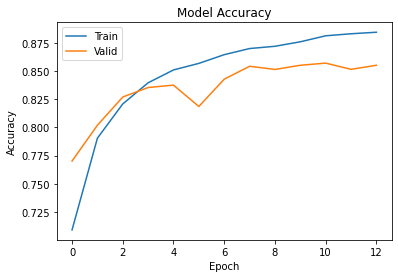

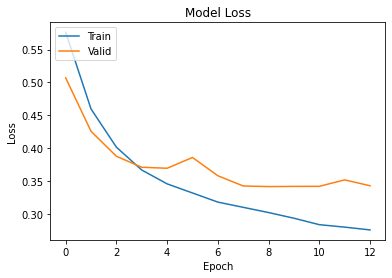

In [ ]:
# Plot history of accuracy during training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig(SAVE_PATH + 'figures/acc_plot.png')
plt.show()

# Plot history of loss during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig(SAVE_PATH + 'figures/loss_plot.png')
plt.show()

**Load and Test Model**

In [ ]:
model = load_model(SAVE_PATH + 'GloVe_LSTM_SA_Classifier.h5')
model.evaluate(x=x_test, y=y_test)

157/157 [==============================] - 2s 10ms/step - loss: 0.3665 - acc: 0.8438


[0.36653441190719604, 0.8438000082969666]

**Plot Confusion Matrix**

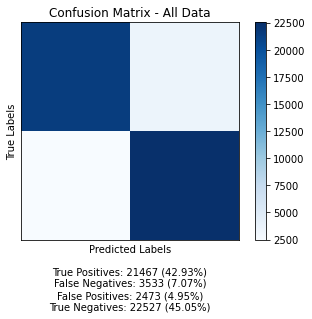

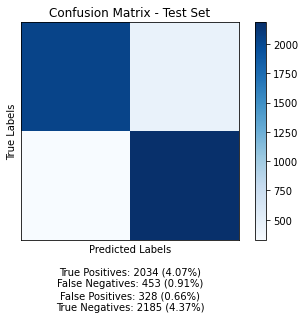

In [ ]:
def get_caption(cm):
  return "\n\nTrue Positives: {} ({}%)\nFalse Negatives: {} ({}%)\nFalse Positives: {} ({}%)\nTrue Negatives: {} ({}%)".format(
    str(cm[0][0]), str(round((cm[0][0]/len(x_vals))*100, 2)),
    str(cm[0][1]), str(round((cm[0][1]/len(x_vals))*100, 2)),
    str(cm[1][0]), str(round((cm[1][0]/len(x_vals))*100, 2)),
    str(cm[1][1]), str(round((cm[1][1]/len(x_vals))*100, 2))
  )
  
# Generate predictions on full dataset
y_preds = model.predict(x_vals)
y_preds = np.where(y_preds > 0.5, 1, 0)
cm = confusion_matrix(y_vals, y_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion Matrix - All Data')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/confusion_matrix_alldata.png', bbox_inches='tight')
plt.show()


# Generate predictions on testing set
y_test_preds = model.predict(x_test)
y_test_preds = np.where(y_test_preds > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_test_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion Matrix - Test Set')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/confusion_matrix_testdata.png', bbox_inches='tight')
plt.show()

**Analyze Results**

In [166]:
# Display messages incorrectly classified
misclass_data = data.loc[y_preds != y_vals]
print("Stemmed Text Given to Model:\n", misclass_data)

# Display the unstemmed version of the misclassified messages
unstemmed_data = pd.read_csv(SAVE_PATH + 'data/Cleaned_No_Stemming_IMDB_Dataset.csv')
misclass_data_readable = unstemmed_data.loc[y_preds != y_vals]
print("\nHuman Readable Unstemmed Version of Text:\n", misclass_data_readable)

Stemmed Text Given to Model:
                                                   review sentiment
11     saw movi came recal scariest scene big bird ea...  negative
16     film simpli remad one bad film fail captur fla...  positive
20     success die hard sequel surpris realli glut di...  positive
48     preston sturgi power glori unseen public nearl...  positive
52     bela lugosi appear sever low budget chiller mo...  positive
...                                                  ...       ...
49945  pictur start good intent bacon scientist test ...  negative
49958  someon love basebal histori especi earli th ce...  negative
49974  part michael disast ten minut charm nineti wor...  negative
49988  first tune morn news thought wow final enterta...  negative
49993  robert colomb two fulltim job he known through...  negative

[6006 rows x 2 columns]

Human Readable Unstemmed Version of Text:
                                                   review sentiment
11     saw movie came recall s

**Distribution of Misclassified Texts**

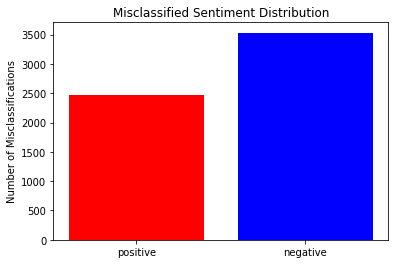

In [173]:
misclass_pos = misclass_data_readable[misclass_data_readable.sentiment == 'positive']
misclass_neg = misclass_data_readable[misclass_data_readable.sentiment == 'negative']

# Plot misclassified distribution
plt.bar(x=['positive', 'negative'], height=[misclass_pos.shape[0], misclass_neg.shape[0]], color=['red', 'blue'])
plt.title('Misclassified Sentiment Distribution')
plt.ylabel('Number of Misclassifications')
plt.savefig(SAVE_PATH + 'figures/misclassification_distr.png')
plt.show()

**Highest Frequency Words Among Misclassifications**

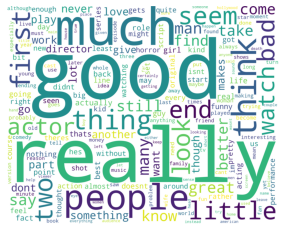

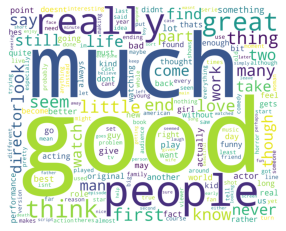

In [198]:
# Add domain specific stop words
exclude = list(wordcloud.STOPWORDS)
exclude.extend([
                    'film', 'films', 'one', 'movie', 'movies', 'characters', 'director'
                    'character', 'scene', 'scenes', 'story', 'time', 'show', 
                    'even', 'plot', 'make', 'made', 'see', 'well', 'way'
              ])
exclude = set(exclude)

# Generate wordcloud based on most common words in positive/negative reviews
misclass_pos_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(misclass_pos['review'].values))
misclass_neg_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(misclass_neg['review'].values))

# Display wordcloud images
plt.imshow(misclass_pos_wordcloud)
plt.axis('off')
plt.show()
plt.imshow(misclass_neg_wordcloud)
plt.axis('off')
plt.show()

# Save word clouds
misclass_pos_wordcloud.to_file(SAVE_PATH + 'figures/misclass_pos_cloud.png')
misclass_neg_wordcloud.to_file(SAVE_PATH + 'figures/misclass_neg_cloud.png')

**Highest Frequency Words Among Correct Classifications**

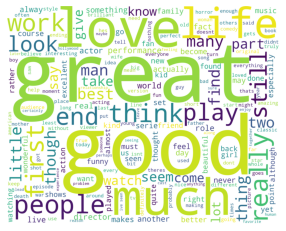

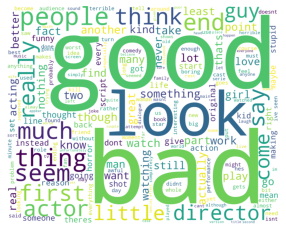

In [197]:
# Separate correctly classified data 
correct_data_readable = unstemmed_data.loc[y_preds == y_vals]
correct_pos = correct_data_readable[correct_data_readable.sentiment == 'positive']
correct_neg = correct_data_readable[correct_data_readable.sentiment == 'negative']

# Add domain specific stop words
exclude = list(wordcloud.STOPWORDS)
exclude.extend([
                    'film', 'films', 'one', 'movie', 'movies', 'characters', 'director'
                    'character', 'scene', 'scenes', 'story', 'time', 'show', 
                    'even', 'plot', 'make', 'made', 'see', 'well', 'way'
              ])
exclude = set(exclude)

# Generate wordcloud based on most common words in positive/negative reviews
correct_pos_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(correct_pos['review'].values))
correct_neg_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(correct_neg['review'].values))

# Display wordcloud images
plt.imshow(correct_pos_wordcloud)
plt.axis('off')
plt.show()
plt.imshow(correct_neg_wordcloud)
plt.axis('off')
plt.show()

# Save word clouds
correct_pos_wordcloud.to_file(SAVE_PATH + 'figures/correct_pos_cloud.png')
correct_neg_wordcloud.to_file(SAVE_PATH + 'figures/correct_neg_cloud.png')

**Excerpts of Misclassified Text**

In [247]:
import textwrap
import random

# Separate data
misclass_pos_text = misclass_pos['review'].values
misclass_neg_text = misclass_neg['review'].values

# Display excerpts of texts in dataset that were misclassified
# Typically include both positive and negative remarks in review
def underline(text): return text + '\n' + ('-' * len(text))

print(underline("Postive Labeled Reviews Predicted Negative:"), "\n")
for i in [90, 164]:
  print(textwrap.fill(misclass_pos_text[i], 75), "\n")

print(underline("Negative Labeled Reviews Predicted Positive:"), "\n")
for i in [66, 551]:
  print(textwrap.fill(misclass_neg_text[i], 75), "\n")

Postive Labeled Reviews Predicted Negative:
------------------------------------------- 

worst movie ive ever seen yet also best movie sci fi original movies
supposed bad thats makes fun line like dinosaur meat well done probably
best quote ever also plot sounds like something pot induced dream imagine
writers waking long night getting high playing dance dance revolution
putting ideas together space marines got alien planet infested dinosaurs
medieval houses protect science team studying planet best idea ever fact
fits complete sci fi original movie checklist guns dinosaurs medieval times
space travel terrible actingso go watch movie dont buy 

without kirsten miller project neednt completed however awe inspiring
beauty talent miss miller would definitely recommend looked actors playing
strong performance wagners dismal attempt honor film bit disappointing
scenes didnt detract entertained mostly criticisms writing plot line group
talent assembled heroic job salvaging disaster charisma